In [6]:
import numpy as np
import pandas as pd
from preprocess import stroke_vector
from model import get_stroke_lstm_model

In [4]:
test_df = pd.read_csv("input/test_simplified.csv")
test_df['drawing'] = test_df['drawing'].map(stroke_vector)

vector = np.stack(test_df['drawing'], 0)

In [16]:
train_shape = (3,)
num_labels = 340

In [17]:
model = get_stroke_lstm_model(train_shape, num_labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, None, 3)           12        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 48)          768       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 48)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          15424     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 96)          18528     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 96)          0         
__________

In [18]:
model.load_weights('stroke_lstm_model_weights.best.hdf5')

In [19]:
print("test size", vector.shape)

test_pred = model.predict(vector, verbose=True, batch_size=4096)

('test size', (112199, 196, 3))
112199/112199 [==============================] - 6s 53us/step


In [22]:
import glob
import os
from sklearn.preprocessing import LabelEncoder


classes = glob.glob("input/train_simplified/*.csv")
classes = [os.path.basename(c).replace(".csv", "") for c in classes]
word_encoder = LabelEncoder()
word_encoder.fit(classes)
print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_[:10]]))

('words', 340, '=>', 'The Eiffel Tower, The Great Wall of China, The Mona Lisa, airplane, alarm clock, ambulance, angel, animal migration, ant, anvil')


In [23]:
top_3_pred = [word_encoder.classes_[np.argsort(-1 * pred)[:3]] for pred in test_pred]
top_3_pred = [' '.join([col.replace(' ', '_') for col in row]) for row in top_3_pred]
top_3_pred[:3]

['radio stereo train', 'hamburger sandwich hockey_puck', 'camel toe hand']

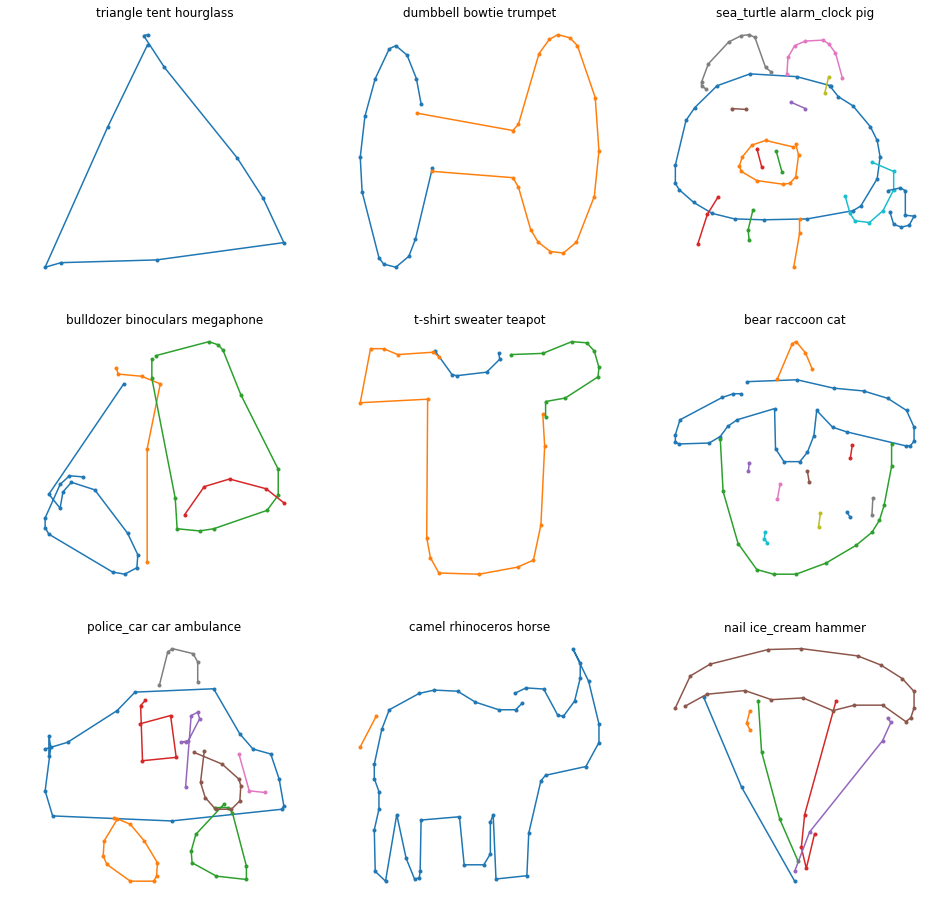

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(vector.shape[0]), size = 9)

for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = vector[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0], 
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(top_3_pred[c_id])

In [26]:
test_df['word'] = top_3_pred
test_df[['key_id', 'word']].to_csv('submission.csv', index=False)